In [ ]:
import sys
sys.path.insert(0, './src/')

import nwq2qis
from nwq2qis import *



##
import numpy as np
np.set_printoptions(suppress=True)
import qiskit
import qiskit.quantum_info as qi
from qiskit_nature.second_q.mappers import JordanWignerMapper, InterleavedQubitMapper
from _gcim_utilis import parse_hamiltonian
import scipy.sparse.linalg as ssl
import scipy.linalg as sl
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import json
from qiskit_ibm_runtime import RuntimeEncoder
from qiskit.primitives import StatevectorEstimator
##

n_orb = 6
n_a = 3
n_b = 3
ducc_lvl = 3
results_file = '../Qubit-ADAPT-VQE/printout_qubit_fbp.txt'
output_folder = 'Example_Outputs/FBP' ## Please create this folder before you run the code
noise_factors = [1,3,5,7,9]
selected_iter = 2 ## which qubit-adapt-vqe iteration, start from 0
FIRST_NTERMS = 59  # first 59 groups of Paulis

mol_name =  f'FreeBasedPorphyrin{n_a+n_b}{n_orb}DUCC{ducc_lvl}'
file_path = "../FBP/FreeBasedPorphyrin.out-xacc"
print("  - Number of electrons:", n_a + n_b)
print("  - Number of orbitals:", n_orb)
print("  - DUCC:", ducc_lvl)
print("  - Target molecule:", mol_name)
print("  - Input file:", file_path)

fermi_ham = parse_hamiltonian(file_path, n_orb, interleaved=False, return_type = 'qiskit')
nwqsim_dict = extract_nwqsim_output(results_file, inverse_pauli=False)

mapper = JordanWignerMapper()
qubit_op = mapper.map(fermi_ham)

true_eigvals = ssl.eigsh(qubit_op.to_matrix(sparse=True),2,which='SA')[0]

errors = np.abs( np.array(nwqsim_dict['energies']) - true_eigvals[0] )
for i, error in enumerate(errors):
    if i > 8:
        break
    print(f"{i}:  {str(nwqsim_dict['operators'][i].paulis[0])}   {error}")

  - Number of electrons: 6
  - Number of orbitals: 6
  - DUCC: 3
  - Target molecule: FreeBasedPorphyrin66DUCC3
  - Input file: ../DUCC-Hamiltonian-Library/FBP/FreeBasedPorphyrin.out-xacc
0:  IXYXXIIIIIII   0.0123183193644536
1:  IIIIIIIXYXXI   0.009412132266220397
2:  IIIIIIIYZZZX   0.009143387921540125
3:  IYZZZXIIIIII   0.008927078743795391
4:  IXZZXIIYZZXI   0.0071785118115030855
5:  IIXXIIIIXYII   0.006601006552841682
6:  IIIIIIIYZZZX   0.005938926870157957
7:  IIXZXIIIYZXI   0.00547883963622553
8:  IXZXIIIXZYII   0.004487241603783332


In [ ]:
pauli_dict, coeff_dict = grouped_pauli_in_dict(qubit_op, use_qwc=True)
pas_ch, cas_ch = pauli_coeff_separation(qubit_op)

## Optimize Parameters

In [ ]:
import nwq2qis
import importlib
importlib.reload(nwq2qis)
from nwq2qis import *

vqe_circ, symbol_params = create_vqe_circ(nwqsim_dict['operators'][:selected_iter+1], 
                                            n_orb*2, n_a+n_b, interleaved=False, half_barriar=True)

## Optimize parameters
def cost_func(parameters):
    """Compute the energy for given parameters."""
    estimator = StatevectorEstimator()
    job = estimator.run([(vqe_circ, qubit_op, parameters)])
    return float( job.result()[0].data.evs )

num_vars = len(nwqsim_dict['parameters'][:selected_iter+1])
optimizer = COBYLA(maxiter=5000, disp=True)
result = optimizer.minimize(cost_func, nwqsim_dict['parameters'][:selected_iter+1])

pre_opt_params = result.x

basis_gates = ['u', 'cx']
trans_vqe_opt = transpile(vqe_circ.assign_parameters(pre_opt_params), basis_gates=basis_gates, 
                          optimization_level=2, seed_transpiler=7)
print(trans_vqe_opt.count_ops(), cost_func(pre_opt_params), nwqsim_dict['energies'][selected_iter])

np.save(f"{output_folder}/optparam-vqe-itr{selected_iter}.npy", pre_opt_params)
pre_opt_params


   Normal return from subroutine COBYLA

   NFVALS =   86   F =-9.867641E+02    MAXCV = 0.000000E+00
   X =-5.764837E-01  -5.767715E-01   5.353437E-02
OrderedDict({'u': 28, 'cx': 19, 'barrier': 1}) -986.7641040677287 -986.7641018705452


array([-0.57648369, -0.57677154,  0.05353437])

## Choose First X groups that has the largest sum of coefficients

In [6]:
import nwq2qis
import importlib
importlib.reload(nwq2qis)
from nwq2qis import *

pauli_dict, coeff_dict = grouped_pauli_in_dict(qubit_op, use_qwc=True)
## Select first N Groups depends on the sum of abs of coefficients
coeffs_selected = dict_sort_and_select(coeff_dict,FIRST_NTERMS)
pauli_selected = {k:v for k,v in pauli_dict.items() if k in coeffs_selected.keys()}
## Construct Partial Hamiltonian
counter = 0
partial_paulis = []
partial_coeffs = []
partial_hamop = None
for k in pauli_selected.keys():
    sub_ham = qiskit.quantum_info.SparsePauliOp(pauli_selected[k], coeffs_selected[k])
    if partial_hamop is None:
        partial_hamop = sub_ham
    else:
        partial_hamop += sub_ham
    counter += 1
## Eigenvalues
partial_eigvals = sl.eigh(partial_hamop.to_matrix(sparse=False))[0]

print("Selected Pauli strings:", len(pauli_selected))
partial_eigvals, abs(partial_eigvals[0] - true_eigvals[0])

Selected Pauli strings: 59


(array([-986.76734685, -986.69267557, -986.69197001, ..., -983.0041199 ,
        -983.00387889, -982.32728781]),
 0.005898407343124745)

### Group Pauli Operators and Generate Circuits

In [9]:
import nwq2qis
import importlib
importlib.reload(nwq2qis)
from nwq2qis import *

pauli_dict_partial, coeff_dict_partial = grouped_pauli_in_dict(partial_hamop, use_qwc=True) ## grouping paulis in the Hamiltonian and separate Pauli strings and Coefficients
circ_dict = commuting_circs(list(pauli_dict_partial.keys()), trans_vqe_opt, add_measure = True, 
                            noise_factors=noise_factors, inverse_pauli = False, noise_type='half') ## Form circuits for each commuting group
circ_dict_nomeasure = commuting_circs(list(pauli_dict_partial.keys()), trans_vqe_opt, add_measure = False, 
                            noise_factors=noise_factors, inverse_pauli = False, noise_type='half') ## Form circuits for each commuting group
print("Number of commuting groups:",len(list(pauli_dict_partial.keys())))
# print(f"Total number of cx gates: {trans_vqe_opt.count_ops()['cx']*len(list(pauli_dict_partial.keys()))}")

## Exact Solutions
theo_state = qi.Statevector.from_instruction(vqe_circ.assign_parameters(pre_opt_params)) ## exact state
theo_energy = theo_state.expectation_value(partial_hamop).real
print(theo_energy, partial_eigvals[0], abs(theo_energy - partial_eigvals[0]))

Number of commuting groups: 60
-986.7608388335083 -986.7673468511236 0.006508017615374229


In [10]:
with open(f"{output_folder}/pauli_dict_partial{len(list(pauli_dict_partial.keys()))}.json", 'w') as f:
    json.dump(pauli_dict_partial, f)
with open(f"{output_folder}/coeff_dict_partial{len(list(pauli_dict_partial.keys()))}.json", 'w') as f:
    json.dump(coeff_dict_partial, f, cls=RuntimeEncoder)

## Infinite Shots

In [11]:
for nf in noise_factors:
    print(f"\nNoise factor: {nf}")
    meas_prob_dict_ideal = {}
    cx_count = 0
    for key, circs in circ_dict_nomeasure.items():
        circ = circs[int((nf-1)/2)]
        cx_count += circ.count_ops()['cx']
        meas_prob_dict_ideal[key] = qiskit_normal_order_switch_vec( qi.Statevector.from_instruction(circ).probabilities(decimals=16)  )
        # meas_prob_dict_ideal[key] =  qi.Statevector.from_instruction(circ).probabilities(decimals=16) 

    final_exp_ideal = est_exp_sampler(pauli_dict_partial, coeff_dict_partial, meas_prob_dict_ideal, debug_state = theo_state) ## compute the expectation value and sum them up
    print(f"  Number of cx gates: {cx_count}")
    print(f"  Final expectation energy: {final_exp_ideal}, Error to qiskit {abs(theo_energy - final_exp_ideal)}, Error to FCI {abs(final_exp_ideal - true_eigvals[0])}")


Noise factor: 1
  Number of cx gates: 1140
  Final expectation energy: -986.7607164974243, Error to qiskit 0.00012233608401857055, Error to FCI 0.012528761042517544

Noise factor: 3
  Number of cx gates: 2700
  Final expectation energy: -986.7607164974238, Error to qiskit 0.0001223360844733179, Error to FCI 0.012528761042972292

Noise factor: 5
  Number of cx gates: 4260
  Final expectation energy: -986.7607164974238, Error to qiskit 0.0001223360844733179, Error to FCI 0.012528761042972292

Noise factor: 7
  Number of cx gates: 5820
  Final expectation energy: -986.7607164974238, Error to qiskit 0.0001223360844733179, Error to FCI 0.012528761042972292

Noise factor: 9
  Number of cx gates: 7380
  Final expectation energy: -986.7607164974238, Error to qiskit 0.0001223360844733179, Error to FCI 0.012528761042972292


## Finite Sampler

In [12]:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

total_shots_used = 0
for nf in noise_factors:
# for nf in [1]:
    print(f"\nNoise factor: {nf}")
    meas_prob_dict_finitesim = {}
    cx_count = 0
    circ_counter = 0
    for key, circs in circ_dict.items():
        total_shots_used += 1024
        temp_circ = circs[int((nf-1)/2)]
        cx_count += temp_circ.count_ops()['cx'] ## 
        meas_quasi_res = sampler.run([temp_circ], shots=1024).result()[0].data.meas.get_counts()
        meas_prob_dict_finitesim[key] = freq_dict_to_prob_array(meas_quasi_res, len(key), endien_switch = True)
        circ_counter += 1

    final_exp_finitesim = est_exp_sampler(pauli_dict_partial, coeff_dict_partial, meas_prob_dict_finitesim) ## compute the expectation value and sum them up
    print(f"  Number of cx gates: {cx_count}")
    print(f"  Final expectation energy: {final_exp_finitesim}, Error to qiskit {abs(theo_energy - final_exp_finitesim)}, Error to FCI {abs(final_exp_finitesim - true_eigvals[0])}")


Noise factor: 1
  Number of cx gates: 1140
  Final expectation energy: -986.7634900424023, Error to qiskit 0.0026512088940080503, Error to FCI 0.009755216064490924

Noise factor: 3
  Number of cx gates: 2700
  Final expectation energy: -986.7571456288804, Error to qiskit 0.003693204627893465, Error to FCI 0.01609962958639244

Noise factor: 5
  Number of cx gates: 4260
  Final expectation energy: -986.7578723667522, Error to qiskit 0.002966466756106456, Error to FCI 0.01537289171460543

Noise factor: 7
  Number of cx gates: 5820
  Final expectation energy: -986.7627648483259, Error to qiskit 0.0019260148176272196, Error to FCI 0.010480410140871754

Noise factor: 9
  Number of cx gates: 7380
  Final expectation energy: -986.76021287613, Error to qiskit 0.0006259573782472216, Error to FCI 0.013032382336746196


In [13]:
final_exp_finitesim - partial_eigvals[0], final_exp_ideal - partial_eigvals[0]

(0.00713397499362145, 0.0066303536998475465)

In [14]:
errors[selected_iter], nwqsim_dict['energies'][selected_iter]

(0.009143387921540125, -986.7641018705452)

In [16]:
## Save infor for unselcted pauli and coefficients
with open(f"{output_folder}/unselected_pauli.json", 'w') as f:
    json.dump(unselected_paulis, f, cls=RuntimeEncoder)
with open(f"{output_folder}/unselected_coeffs.json", 'w') as f:
    json.dump(unselected_coeffs, f, cls=RuntimeEncoder)
## Save infor for selected pauli and coefficients
with open(f"{output_folder}/selected_pauli.json", 'w') as f:
    json.dump(pauli_selected, f, cls=RuntimeEncoder)
with open(f"{output_folder}/selected_coeffs.json", 'w') as f:
    json.dump(coeffs_selected, f, cls=RuntimeEncoder)

## To Quantinuum circuit

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
import qnexus as qnx
import datetime
# qnx.login()

project = qnx.projects.get_or_create("VQE FBP nf 13579 Simu CX Half ZNE")
qnx.context.set_active_project(project)
name_suffix = f'itr{selected_iter}'
config = qnx.QuantinuumConfig(device_name="H1-Emulator")

job_path = pathlib.Path(f'{output_folder}/itr{selected_iter}_job')
job_path.mkdir(parents=True, exist_ok=True) 

qnx.quotas.get_all().df()

,name,description,usage,quota
0,simulation,"Total CPU running time, in seconds.",3453.736968,No quota set for user
1,database_usage,Total megabytes used to store scientific data.,54.421495,No quota set for user
2,compilation,"Total CPU running time, in seconds.",112.148045,No quota set for user
3,jupyterhub,"Total Jupyterhub notebook server running time,...",11120.000000,No quota set for user


In [ ]:
qtm_pauli_arr = []
qtm_circ_arr = []

for key, circs in circ_dict.items():
    for nf in noise_factors:
        circ = circs[int((nf-1)/2)]
        pname = f"{key}-{nf}"
        qtm_c = qiskit_to_tk(circ)
        ref_circuit = qnx.circuits.upload(
            circuit=qtm_c, 
            name=f"{pname}-{name_suffix}", 
        )
        qtm_pauli_arr.append(pname)
        qtm_circ_arr.append(ref_circuit)


ref_compile_job = qnx.start_compile_job(
    circuits=qtm_circ_arr,
    optimisation_level=0,
    backend_config=config,
    name=f"vqe-{name_suffix}-FBP2"
)

print(ref_compile_job.annotations.name)
print(f"{job_path}/paulikey-{ref_compile_job.annotations.name}.npy")
np.save(f"{job_path}/paulikey-{ref_compile_job.annotations.name}.npy", qtm_pauli_arr)

print(ref_compile_job)

vqe-itr2-FBP2
FBPChop_Outputs_CXHalfZNE_Test_Longer/itr2_job/paulikey-vqe-itr2-FBP2.npy
id=UUID('f70d0375-8858-451a-ba71-bc4dd0254a49') annotations=Annotations(name='vqe-itr2-FBP2', description='', properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 43, 43, 807824, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 43, 43, 807824, tzinfo=TzInfo(UTC))) job_type=<JobType.COMPILE: 'compile'> last_status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'> last_message='' project=ProjectRef(id=UUID('de555a4a-fe78-45f5-a799-43d87c8a62f5'), annotations=Annotations(name='VQE FBP nf 13579 Simu CX Half ZNE', description=None, properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 42, 57, 835643, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 42, 57, 835643, tzinfo=TzInfo(UTC))), contents_modified=datetime.datetime(2025, 5, 29, 23, 42, 57, 840284, tzinfo=TzInfo(UTC)), archived=False, type='ProjectRef') type='CompileJobRef'


In [22]:
from pathlib import Path
qnx.filesystem.save(
    ref=ref_compile_job,
    path=Path.cwd() / job_path / f"job-ref_comp-{ref_compile_job.annotations.name}",
    mkdir=True,
)

In [23]:
ref_job_name = f"vqe-itr{selected_iter}-FBP2"
ref_compile_job = qnx.filesystem.load(
    path=Path.cwd() / job_path / f"job-ref_comp-{ref_job_name}",
)
ref_compile_job

CompileJobRef(id=UUID('f70d0375-8858-451a-ba71-bc4dd0254a49'), annotations=Annotations(name='vqe-itr2-FBP2', description='', properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 43, 43, 807824, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 43, 43, 807824, tzinfo=TzInfo(UTC))), job_type=<JobType.COMPILE: 'compile'>, last_status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, last_message='', project=ProjectRef(id=UUID('de555a4a-fe78-45f5-a799-43d87c8a62f5'), annotations=Annotations(name='VQE FBP nf 13579 Simu CX Half ZNE', description=None, properties=OrderedDict(), created=datetime.datetime(2025, 5, 29, 23, 42, 57, 835643, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 5, 29, 23, 42, 57, 835643, tzinfo=TzInfo(UTC))), contents_modified=datetime.datetime(2025, 5, 29, 23, 42, 57, 840284, tzinfo=TzInfo(UTC)), archived=False, type='ProjectRef'), type='CompileJobRef')

## Estimate costs

In [24]:
ref_compiled_job_arr = [item for item in qnx.jobs.results(ref_compile_job)]
ref_compiled_circuits = [item.get_output() for item in ref_compiled_job_arr]
downloaded_circuits = [item.download_circuit() for item in ref_compiled_circuits]
ref_compiled_job_arr[0].df()

,name,description,created,modified,project,id
0,XZZZZYXZZZZY-1-itr2-compilation,,2025-05-29 23:44:30.956794+00:00,2025-05-29 23:44:30.970742+00:00,VQE FBP nf 13579 Simu CX Half ZNE,62b6202f-c7fa-4887-8cd6-9f7e959051b7


In [25]:
qtm_qis_circs = [tk_to_qiskit(dc) for dc in downloaded_circuits]
qtm_qis_rzzs = [dc.count_ops()['rzz'] for dc in qtm_qis_circs]
np.save(f"{job_path}/rzzcount-{ref_compile_job.annotations.name}.npy", qtm_qis_rzzs)
print(np.mean(qtm_qis_rzzs))

71.0


## Submit to execute

In [26]:
shots = 1024
execute_job_ref = qnx.start_execute_job(
    circuits=ref_compiled_circuits,
    name=f"{ref_job_name}_{shots}shots",
    n_shots=[shots]* len(ref_compiled_circuits),
    backend_config=config,
    project=project,
)

print(execute_job_ref.annotations.name)

vqe-itr2-FBP2_1024shots


In [29]:
# Retrieve a ExecutionResultRef for every Circuit that was run
execute_job_result_refs = qnx.jobs.results(execute_job_ref)

from pathlib import Path
qnx.filesystem.save(
    ref=execute_job_ref,
    path=Path.cwd() / job_path / f"job-exec-{execute_job_ref.annotations.name}",
    mkdir=True,
)

execute_job_result_refs.df()

,name,description,created,modified,project,id
0,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,439d0e02-bf51-4f20-adc2-b573393033c6
1,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,b7958d3c-2712-4f70-bfdd-abd19d007c5a
2,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,c4f6fdc9-be37-4cfe-91b2-b2cac0b289af
3,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,ff9dd304-bc51-4c36-8241-9abace8a06d9
4,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,67a1b5da-ffce-4436-b21f-f5463aa7997e
...,...,...,...,...,...,...
295,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,ff48150f-3293-4518-b0ed-24fa5e452a31
296,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,a47a8492-d5cb-46c5-904f-8e7458c0304e
297,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,aababd98-3457-49ac-b76c-b2e7366d4e81
298,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,4cbed3c1-8df0-4069-81a1-8173b22ed56f


#### Data Processing for newer results

In [30]:
from pathlib import Path

exec_job_name = f"vqe-itr{selected_iter}-FBP2_{shots}shots"
execute_job_ref = qnx.filesystem.load(
    path=Path.cwd() / job_path / f"job-exec-{exec_job_name}",
)

qtm_pauli_arr = np.load(f"{job_path}/paulikey-{exec_job_name.split('_')[0]}.npy")
execute_job_result_refs = qnx.jobs.results(execute_job_ref)
execute_job_result_refs.df()

,name,description,created,modified,project,id
0,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,439d0e02-bf51-4f20-adc2-b573393033c6
1,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,b7958d3c-2712-4f70-bfdd-abd19d007c5a
2,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,c4f6fdc9-be37-4cfe-91b2-b2cac0b289af
3,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,ff9dd304-bc51-4c36-8241-9abace8a06d9
4,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,67a1b5da-ffce-4436-b21f-f5463aa7997e
...,...,...,...,...,...,...
295,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,ff48150f-3293-4518-b0ed-24fa5e452a31
296,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,a47a8492-d5cb-46c5-904f-8e7458c0304e
297,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,aababd98-3457-49ac-b76c-b2e7366d4e81
298,vqe-itr2-FBP2_1024shots,,2025-05-29 23:50:24.478298+00:00,2025-05-29 23:50:24.478298+00:00,VQE FBP nf 13579 Simu CX Half ZNE,4cbed3c1-8df0-4069-81a1-8173b22ed56f


In [ ]:
qtm_results = { str(nf):{} for nf in noise_factors} ## defined in earlier data processing
for ps, res_ref in zip(qtm_pauli_arr, execute_job_result_refs):
    pauli_str, nf = ps.split('-')
    qtm_results[nf][pauli_str] = freq_dict_to_prob_array( res_ref.download_result().get_counts(), len(pauli_str), endien_switch = False)
# np.array(qtm_results['1'][qtm_pauli_arr[0].split('-')[0]])
len(qtm_results['1']),len(qtm_results['3']), len(qtm_results['5'])

(60, 60, 60)

In [38]:
qtm_exps = []
qtm_vars = []
# noise_factors = [1,3,5]
for nf in noise_factors:
    print(f"\nNoise factor: {nf}")
    final_exp_qtmh1, final_var_qtmh1 = est_exp_sampler(pauli_dict_partial, coeff_dict_partial, qtm_results[str(nf)], return_var=True, num_shots=1024) ## compute the expectation value and sum them up
    qtm_exps.append(final_exp_qtmh1)
    qtm_vars.append(final_var_qtmh1)
    print(f"  Estimation {final_exp_qtmh1} +- {np.sqrt(final_var_qtmh1)}, Error to qiskit {abs(theo_energy - final_exp_qtmh1)}, Error to Partial FCI {abs(final_exp_qtmh1 - partial_eigvals[0])}")


Noise factor: 1
  Estimation -986.7495355773109 +- 0.0037401470611526408, Error to qiskit 0.011303256197379596, Error to Partial FCI 0.017811273812753825

Noise factor: 3
  Estimation -986.7348587847246 +- 0.004224183886778091, Error to qiskit 0.0259800487837083, Error to Partial FCI 0.03248806639908253

Noise factor: 5
  Estimation -986.7256429789732 +- 0.0048486814381407005, Error to qiskit 0.03519585453511809, Error to Partial FCI 0.041703872150492316

Noise factor: 7
  Estimation -986.7095472955184 +- 0.005222521019222005, Error to qiskit 0.05129153798986863, Error to Partial FCI 0.05779955560524286

Noise factor: 9
  Estimation -986.707827951741 +- 0.0055442095499970085, Error to qiskit 0.053010881767249884, Error to Partial FCI 0.05951889938262411


In [40]:
np.set_printoptions(suppress=True)
qtm_vars

[1.3988700039048736e-05,
 1.7843729509315666e-05,
 2.350971168857017e-05,
 2.727472579621565e-05,
 3.073825953427803e-05]

R^2 value: 0.9594560412536409


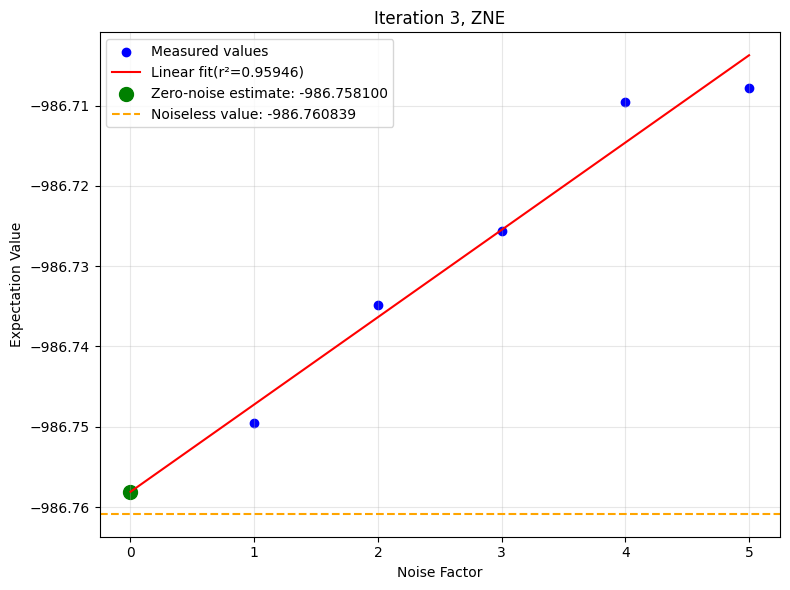

In [ ]:
from nwq2qis import *
noise_factors_half = [1,2,3,4,5]
ex_exp, popt = extrapolate_to_zero_noise(noise_factors_half, qtm_exps, extrapolation_method='linear', 
                                   plot=True, plot_title=f"Iteration {selected_iter+1}, ZNE",
                                   plot_horizontal_line=theo_energy,
                                   plot_horizontal_line_legend="Noiseless value")
np.save(f"{job_path}/zneexp-{exec_job_name}.npy", [ex_exp]+list(qtm_exps))
np.save(f"{job_path}/znepopt-{exec_job_name}.npy", popt)

In [46]:
intercept_with_uncertainty(noise_factors_half, qtm_exps, alpha=0.05)

{'intercept': -986.7581005397574,
 'intercept_se': 0.004279791543476959,
 'uncertainty': 0.013620206784925083,
 'CI': (-986.7717207465423, -986.7444803329724)}

In [47]:
qtm_exps, abs(ex_exp-theo_energy)

([-986.7495355773109,
  -986.7348587847246,
  -986.7256429789732,
  -986.7095472955184,
  -986.707827951741],
 0.0027388737769342697)

In [48]:
ex_exp, theo_energy, partial_eigvals[0], true_eigvals[0]

(-986.7580999597313,
 -986.7608388335083,
 -986.7673468511236,
 -986.7732452584668)

In [49]:
abs(ex_exp - partial_eigvals[0]),abs(theo_energy - partial_eigvals[0])

(0.009246891392308498, 0.006508017615374229)

In [50]:
abs(ex_exp - true_eigvals[0]),abs(theo_energy - true_eigvals[0])

(0.015145298735433244, 0.012406424958498974)

In [51]:
-986.6465 - true_eigvals[0], -986.8192 - true_eigvals[0]

(0.12674525846682627, -0.045954741533250854)